In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

grav    = 9.80616    # acceleration of gravity ~ m/s^2

file names

In [2]:
# normalization scale factors (nc)
fn_mli_mean  = '../norm_factors/mli_mean.nc'
fn_mli_min   = '../norm_factors/mli_min.nc'
fn_mli_max   = '../norm_factors/mli_max.nc'
fn_mlo_scale = '../norm_factors/mlo_scale.nc'

# ml input
fn_x_true = fn_x_true = '../npy_data_conversion/npy_files/val_input_stride6.npy'

# grid info
fn_grid = './E3SM-MMF_ne4_grid-info.nc'

load data from files

In [3]:
x_true = np.load(fn_x_true).astype(np.float64)
ds_grid = xr.open_dataset(fn_grid) # has ncol:384
mli_mean  = xr.open_dataset(fn_mli_mean)
mli_min   = xr.open_dataset(fn_mli_min)
mli_max   = xr.open_dataset(fn_mli_max)

make time-mean surface pressure (state_ps)

In [4]:
# read surface pressure, state_ps
x_true = np.load(fn_x_true).astype(np.float64)
state_ps =  xr.DataArray(x_true[:,120], dims=('sample'), name='state_ps')
state_ps = state_ps * (mli_max['state_ps'] - mli_min['state_ps']) + mli_mean['state_ps']

# reshape the sample dimension, (sample) -> (time, ncol)
N_ncol = len(ds_grid['ncol'])
N_sample = len(state_ps)
N_timestep = int(N_sample/N_ncol)

dim_ncol     = np.arange(N_ncol)
dim_timestep = np.arange(N_timestep)

new_ind = pd.MultiIndex.from_product([dim_timestep, dim_ncol],
                                     names=['time', 'ncol'])

state_ps = state_ps.assign_coords(sample=new_ind).unstack('sample')

# now state_ps = state_ps(time, ncol)
# make time avg
state_ps = state_ps.mean('time')

make dp/g weights

In [5]:
# calculate pressure at grid interfaces
dp = ds_grid['hyai']*ds_grid['P0'] + ds_grid['hybi']*state_ps

# to numpy array
dp = dp.values

# make pressure thickness
dp = dp[1:,:] - dp[:-1,:]

# multiply 1/grav
dp = dp * 1/grav

dp.shape

(60, 384)

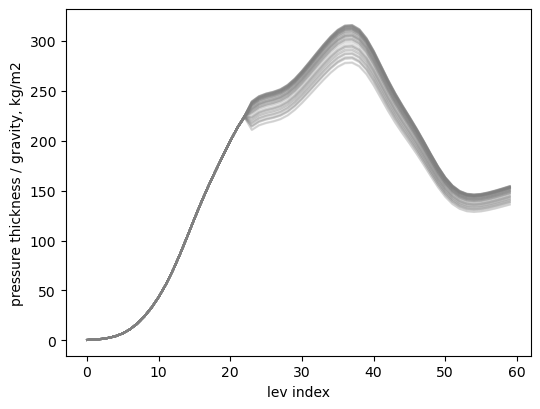

In [6]:
for kcol in range(dp.shape[0]):
    plt.plot(dp[:,kcol], color='grey', alpha=.2)
plt.gca().set_ylabel('pressure thickness / gravity, kg/m2')
plt.gca().set_xlabel('lev index')
plt.gcf().set_size_inches(6,4.5)

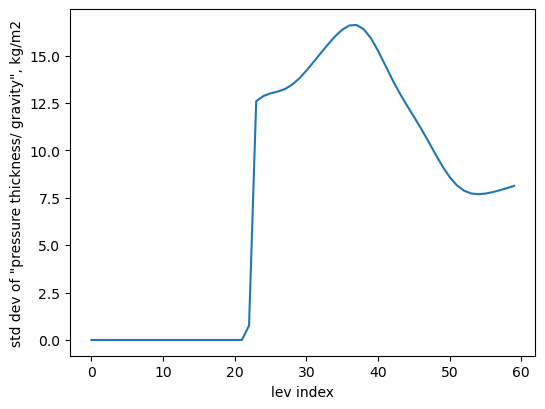

In [7]:
plt.plot(np.std(dp,axis=1))
plt.gca().set_ylabel('std dev of "pressure thickness/ gravity", kg/m2')
plt.gca().set_xlabel('lev index')
plt.gcf().set_size_inches(6,4.5)

save to npy files

In [8]:
# dp/g
fn_save = './grid_info_npy_files/ne4.val-stride-6.dp-over-g.npy'
np.save(fn_save, dp)

In [9]:
# area, lon, lat
for kvar in ['area', 'lon', 'lat']:
    fn_save = f'./grid_info_npy_files/ne4.{kvar}.npy'
    np.save(fn_save, ds_grid[kvar].values)

In [10]:
!ls ./grid_info_npy_files/

ne4.area.npy  ne4.lat.npy  ne4.lon.npy	ne4.val-stride-6.dp-over-g.npy
